<a href="https://colab.research.google.com/github/arielbakal/vehicle_routing_problem/blob/main/vehicle_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle routing optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Lineal and Simple Routing

### Routing on the plane

In [2]:
def generate_locations(depot_coord, locations_quantity, map_limit):

  x_components = np.random.randint(map_limit[0], map_limit[1], size=locations_quantity)
  y_components = np.random.randint(map_limit[0], map_limit[1], size=locations_quantity)
  locations = [np.array([x, y]) for x, y in zip(x_components, y_components)]

  return locations

Generating a list of $(x,y)$ random points

In [3]:
def routing( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [np.linalg.norm( location_from - location ) for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

  Then i start tracing routes between the start point and its closest point, then the next closest point and so on, until it ends out of points and ends at the starting point

In [4]:
def map_routes(routes):

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  x_coords = [point[0] for route in routes for point in route]
  y_coords = [point[1] for route in routes for point in route]

  for route in routes:
      axs[1].arrow(route[0][0], route[0][1], route[1][0] - route[0][0], route[1][1] - route[0][1], color='gray', width=0.025, length_includes_head=True, head_width=1.5)
      axs[1].plot([route[0][0], route[1][0]], [route[0][1], route[1][1]], color='gray')

  axs[1].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[1].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[1].set_xlabel('X')
  axs[1].set_ylabel('Y')
  axs[1].set_title('Routes')

  axs[0].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[0].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[0].set_xlabel('X')
  axs[0].set_ylabel('Y')
  axs[0].set_title('Map')

  plt.tight_layout()
  plt.legend()
  plt.show()

At first, i plot a Map with all the points and then the Routes Map

In [5]:
def run_algorithm( depot_coord, locations_quantity, map_limit ):

  locations_local = generate_locations( depot_coord, locations_quantity, map_limit )
  routes = routing( depot_coord, locations_local )
  map_routes(routes)

Lastly, i need a function whichs runs the whole algorithm

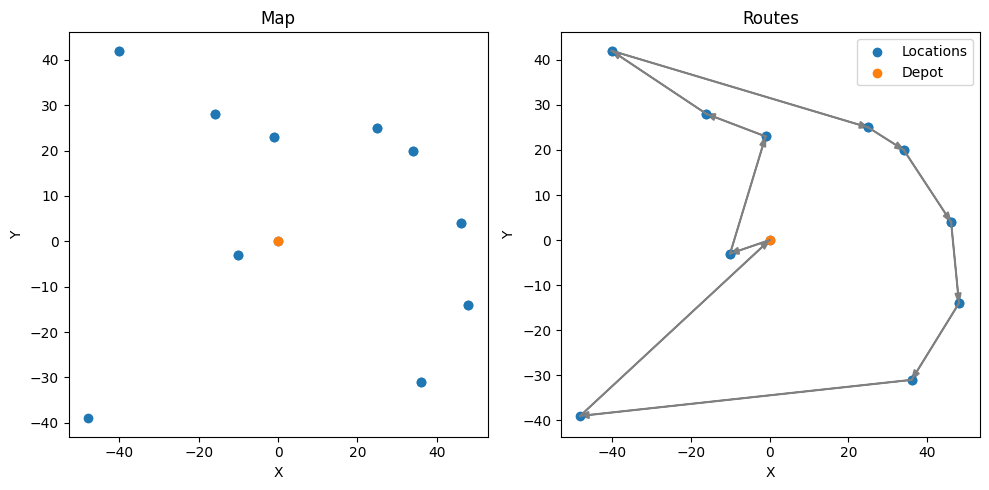

In [6]:
run_algorithm( (0,0), 10, (-50,50) )

This should be enough to understand what we are willing to achieved.

Here we are working with cartesian points, but we aren't positioned on a plane map. As we are on a non-perfect sphere, i'll be talking about latitude and longitude.

### Routing on the sphere ( lat, long )

These are their limits:

$latitude \in [-90,90]$
, $longitude \in [-180,180]$

In [7]:
def generate_geolocations(depot_coord, locations_quantity):

    lat_components = np.random.uniform(-90, 90, size=locations_quantity)
    lon_components = np.random.uniform(-180, 180, size=locations_quantity)

    locations = [np.array([lat, lon]) for lat, lon in zip(lat_components, lon_components)]

    return locations

Since we are in a non-perfect sphere, we cant do euclidean distance anymore. Instead, we've to do some trigonometric calculations, like using the Haversine formula whichs calculates the distance between two points on a sphere.

You can build a function for this, but there is a python library who does this work for us.

In [8]:
from geopy.distance import geodesic

Adapting our routing function

In [9]:
def georouting( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [geodesic(location_from, location).kilometers for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

In [10]:
def run_algorithm( depot_coord, locations_quantity ):

  locations_local = generate_geolocations( depot_coord, locations_quantity )
  routes = georouting( depot_coord, locations_local )
  map_routes(routes)

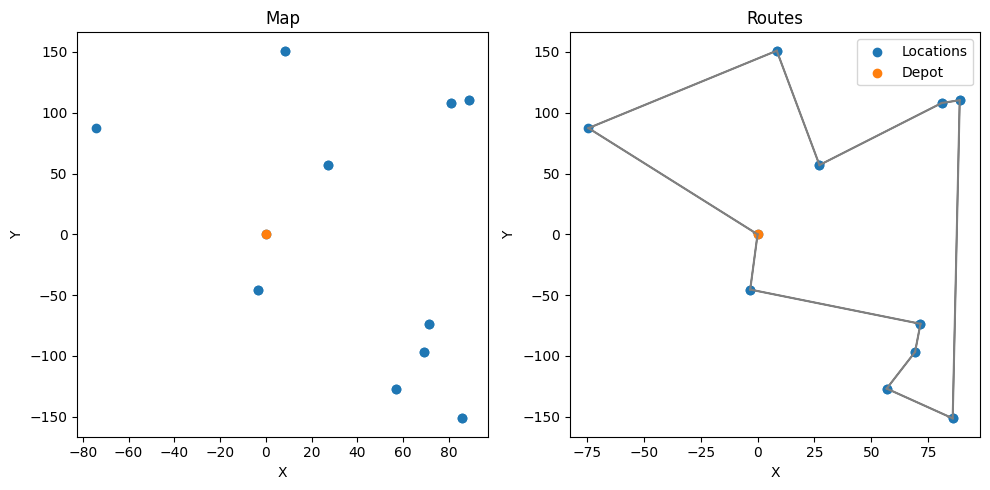

In [11]:
run_algorithm( (0,0), 10 )

This routes may look wrong, but we are representing our sphere points as plane poitns.

### Algorithm working as a Service

Lets import a bigger set of locations

In [12]:
import pandas as pd

In [13]:
file_path = "/content/sample_data/data.json"

df = pd.read_json(file_path)

In [14]:
print(df)

         id    latitud     longitud
0    639933 -32.622739   -60.144791
1    639941 -34.810421  -58.1743186
2    639942 -34.863270  -58.1832665
3    640436 -31.537500    -68.53639
4    640438 -34.610164  -58.9564347
..      ...        ...          ...
516  642262 -31.435560    -62.07139
517  642263 -32.941525   -60.665639
518  642264 -31.241309   -64.466576
519  642265 -31.416670    -64.18333
520  642266 -31.662700     -60.7653

[521 rows x 3 columns]


Here we have 521 locations

In [15]:
depot_coord = tuple(df.loc[0])
locations = [tuple(df.loc[i]) for i in range(1, df.shape[0])]

We have to adapt our routing function, since we have 3-tuples

In [16]:
def georouting( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [geodesic(location_from[1:], location[1:]).kilometers for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

Now, lets play the role of being a service. Since we get a json file, lets return a json with all the routes

In [17]:
import json

In [18]:
def routes_tojson( routes ):
  json_data = {}

  for i, route in enumerate(routes):
      route_key = i
      json_data[route_key] = {}
      for j, (location_from, lat_from, lon_from) in enumerate(route):
          if isinstance(location_from, np.int64):
              location_from = location_from.item()
          if j == 0:
              location_key = "departure"
          else:
              location_key = "arrival"
          json_data[route_key][location_key] = {
              "id": location_from,
              "latitude": lat_from,
              "longitude": lon_from
          }

  with open("routes.json", "w") as file:
      json.dump(json_data, file)

In [19]:
routes = georouting( depot_coord, locations)

KeyboardInterrupt: ignored

In [ ]:
routes_tojson(routes)

## Linear and Complex Routing

Lets work with some new variables, such like time, velocity and vehicle quantity.

I'll assume that the truck's average velocity is 40km/h

In [20]:
trucks_vel = 40 # km/h

Adapting this variable to the routing function:

In [ ]:
def georouting( depot_coord, locations, trucks_velocity ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []
  duration = 0

  while len(locations_local) != 0:
    distances = [geodesic(location_from[1:], location[1:]).kilometers for location in locations_local]
    duration += min(distances) / trucks_velocity
    location_index = np.argmin( distances )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]
  duration += geodesic(routes[-1][1][1:], depot_coord[1:]).kilometers / trucks_velocity

  return routes, duration

In [ ]:
routes, duration = georouting( depot_coord, locations, trucks_vel)

In [ ]:
print("Duration =", round(duration, 2), "hours")

Now lets add a new variable, time.

In [ ]:
def georouting( depot_coord, locations, trucks_velocity, time ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []
  duration = 0

  while len(locations_local) != 0 and duration <= time:
    if ( (geodesic(location_from[1:], depot_coord[1:]).kilometers / trucks_velocity) + duration ) > time:
      print((geodesic(location_from[1:], depot_coord[1:]).kilometers / trucks_velocity) + duration )
      routes.pop()
      break
    distances = [geodesic(location_from[1:], location[1:]).kilometers for location in locations_local]
    duration += min(distances) / trucks_velocity
    location_index = np.argmin( distances )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]
  duration += geodesic(routes[-1][1][1:], depot_coord[1:]).kilometers / trucks_velocity

  return routes, duration

In [ ]:
routes, duration = georouting( depot_coord, locations, trucks_vel, 15)

In [ ]:
print(len(routes))
print(duration)

In [ ]:
def map_georoutes(routes):

  routes = [[location[1:] for location in route] for route in routes] # remove id
  routes = [[(float(lat), float(long)) for lat, long in route] for route in routes] # transform strings to floats

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  x_coords = [point[0] for route in routes for point in route]
  y_coords = [point[1] for route in routes for point in route]

  for route in routes:
      axs[1].arrow(route[0][0], route[0][1], route[1][0] - route[0][0], route[1][1] - route[0][1], color='gray')
      axs[1].plot([route[0][0], route[1][0]], [route[0][1], route[1][1]], color='gray')

  axs[1].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[1].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[1].set_xlabel('X')
  axs[1].set_ylabel('Y')
  axs[1].set_title('Routes')

  axs[0].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[0].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[0].set_xlabel('X')
  axs[0].set_ylabel('Y')
  axs[0].set_title('Map')

  plt.tight_layout()
  plt.legend()
  plt.show()

In [ ]:
map_georoutes( routes )

We achieved to do the most quantity of routes between x time. Lets implement a function whichs given this variables: trucks, time, avg_vel, locations, depot. returns all the routes should take the trucks

In [21]:
def multi_routing( depot_coord, locations, trucks, trucks_velocity, time ):

  depot_coord_local = depot_coord
  locations_local = locations[:]
  trucks_routes = []
  routes_durations = []

  for truck in range(trucks):
    last_location = []
    location_from = depot_coord_local
    routes = []
    duration = 0
    locations_quantity = 0
    while len(locations_local) != 0 and duration <= time:
      if ( (geodesic(location_from[1:], depot_coord[1:]).kilometers / trucks_velocity) + duration ) > time:
        locations_local.append(location_from)
        locations_quantity -= 1
        routes = routes[:-1]
        print("\nTruck ",truck)
        print("Done",locations_quantity,"locations in",round(duration,2), "hours.", len(locations_local), "left" )
        break
      distances = [geodesic(location_from[1:], location[1:]).kilometers for location in locations_local]
      duration += min(distances) / trucks_velocity
      location_index = np.argmin( distances )
      location_to = locations_local[ location_index ]
      routes.append([location_from,location_to])
      location_from = location_to
      locations_local.pop(location_index)
      locations_quantity += 1
    if len(locations_local) == 0:
      routes = routes + [ [routes[-1][1] , depot_coord] ]
      duration += geodesic(routes[-1][1][1:], depot_coord[1:]).kilometers / trucks_velocity
      print("\nTruck ",truck)
      print("Done",locations_quantity,"locations in",round(duration,2), "hours.", len(locations_local), "left\n" )
      print("Unused trucks:", trucks - (truck+1))
      trucks_routes.append(routes)
      routes_durations.append(duration)
      break
    if len(routes) == 0:
      print("\nCant reach location with stablished time")
      print("Unused trucks:", trucks - (truck+1))
      break
    last_location = routes[-1][1]
    routes.append([last_location , depot_coord_local])
    duration += geodesic(last_location[1:], depot_coord_local[1:]).kilometers / trucks_velocity
    trucks_routes.append(routes)
    routes_durations.append(duration)

  return trucks_routes, routes_durations

Lets clean our data and fixed it to a range of 150km

In [22]:
file_path = "/content/sample_data/data.json"

df = pd.read_json(file_path)
df = df[df['longitud'] != '']
df = df.reset_index(drop=True)

depot_coord = tuple(df.loc[0])
locations = [tuple(df.loc[i]) for i in range(1, df.shape[0])]
limited_locations = []

for location in locations:
  if (geodesic(location[1:], depot_coord[1:]).kilometers <= 150):
    limited_locations.append(location)

print(len(locations))
print(len(limited_locations))

518
51


In [23]:
trucks_routes, routes_durations = multi_routing( depot_coord, limited_locations, 100, 40, 10 )


Truck  0
Done 17 locations in 7.46 hours. 34 left

Truck  1
Done 20 locations in 9.48 hours. 14 left

Truck  2
Done 5 locations in 8.27 hours. 9 left

Truck  3
Done 9 locations in 6.66 hours. 0 left

Unused trucks: 96


Now we implement a mapping function to visualize what we're doing

In [24]:
def mapping_routes( locations, trucks_routes ):

  plt.figure(figsize=(20, 8))

  for routes in trucks_routes:

    routes_local = routes[:]
    routes_local = [[location[1:] for location in route] for route in routes_local] # remove id
    routes_local = [[(float(lat), float(long)) for lat, long in route] for route in routes_local] # transform strings to floats
    depot = routes_local[0][0]

    for route in routes_local:
        plt.arrow(route[0][0], route[0][1], route[1][0] - route[0][0], route[1][1] - route[0][1], color='gray')
        plt.plot([route[0][0], route[1][0]], [route[0][1], route[1][1]], color='gray')

  locations_local = locations[:]
  lat_coords = [float(location[1:][0]) for location in locations_local]
  long_coords = [float(location[1:][1]) for location in locations_local]

  plt.scatter(lat_coords[:-2], long_coords[:-2], label='Locations')
  plt.scatter(depot[0], depot[1], label='Depot')
  plt.xlabel('latitude')
  plt.ylabel('longitude')
  plt.title('Map')

  plt.tight_layout()
  plt.legend()
  plt.show()